In [284]:
# Downgrade NumPy below 2.0
!pip install --upgrade "numpy<2"

In [285]:
# Then install / reinstall the rest (excluding numpy)
!pip install --upgrade \
    pandas scikit-learn xgboost matplotlib seaborn \
    opencv-python-headless pillow tensorflow

  Using cached numpy-2.2.6-cp311-cp311-macosx_14_0_arm64.whl.metadata (62 kB)
  Using cached numpy-2.1.3-cp311-cp311-macosx_14_0_arm64.whl.metadata (62 kB)
  Using cached pygments-2.19.2-py3-none-any.whl.metadata (2.5 kB)
Using cached numpy-2.1.3-cp311-cp311-macosx_14_0_arm64.whl (5.4 MB)
Using cached pygments-2.19.2-py3-none-any.whl (1.2 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.0 requires FuzzyTM>=0.4.0, which is not installed.
streamlit 1.30.0 requires numpy<2,>=1.19.3, but you have numpy 2.1.3 which is incompatible.
streamlit 1.30.0 requires packaging<24,>=16.8, but you have packaging 25.0 which is incompatible.
streamlit 1.30.0 requires pillow<11,>=7.1.0, but you have pillow 11.3.0 which

In [286]:
import os
import zipfile
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import mutual_info_classif, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

import cv2
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.manifold import TSNE

In [287]:
import pandas as pd, numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler

# 1) Load & drop IDs
data = pd.read_csv('/Users/arshzair/Downloads/amazon_phones_sales_dataset.csv')

missing_values = data.isna()
print(missing_values.any().any())

data.columns = (
    data.columns
        .str.strip()
        .str.lower()
        .str.replace(' ', '_')
        .str.replace(r'[^\w_]', '', regex=True)
)

# 1) Drop any rows where the target is missing
data = data[data['best_seller_last_month'].notna()].reset_index(drop=True)

# 2) Drop unneeded identifier columns
data.drop(columns=[
    'asin','name','model','cpu_model',
    'charging_time','wireless_network','cpu_speed'
], inplace=True, errors='ignore')

print(data.dtypes)

color_freq = data['color'].value_counts(normalize=True)
keep       = color_freq[color_freq > 0.01].index
data['color_grp']  = data['color'].where(data['color'].isin(keep), 'other')
data = pd.concat([data, pd.get_dummies(data['color_grp'], prefix='color', drop_first=True)], axis=1)
data['color_freq'] = data['color_grp'].map(color_freq).fillna(0)
data.drop(columns=['color','color_grp'], inplace=True)

# 3) Other categoricals: Brand, OS, Wireless Carrier, Cellular Technology
for col in ['Brand','OS','Wireless Carrier','Cellular Technology']:
    if col in data.columns:
        freq = data[col].value_counts(normalize=True)
        keep = freq[freq > 0.01].index
        group = f"{col}_grp"
        data[group] = data[col].where(data[col].isin(keep), 'Other')
        dummies = pd.get_dummies(data[group], prefix=col, drop_first=True)
        data = pd.concat([data, dummies], axis=1)
        data[f"{col}_freq"] = data[group].map(freq).fillna(0)
        data.drop(columns=[col, group], inplace=True)

# 4) Extract numeric specs
def extract_num(x):
    s = ''.join(ch for ch in str(x) if ch.isdigit() or ch=='.')
    return float(s) if s else np.nan

for col in ['Battery Capacity','Battery Power','RAM','Storage','Screen Size']:
    if col in data.columns:
        data[col] = data[col].apply(extract_num)

# 5) Clean Discount
if 'Discount' in data.columns:
    data['Discount'] = (data['Discount']
                        .str.rstrip('%')
                        .replace('-', '0')
                        .astype(float) / 100)

# 6) Impute missing values
num_cols = data.select_dtypes(include=[np.number]).columns
cat_cols = data.select_dtypes(include=['object']).columns
data[num_cols] = SimpleImputer(strategy='median').fit_transform(data[num_cols])
data[cat_cols] = SimpleImputer(strategy='most_frequent').fit_transform(data[cat_cols])

# 7) Label-encode remaining categoricals
for c in cat_cols:
    data[c] = LabelEncoder().fit_transform(data[c])

True
color                         object
ratings                      float64
number_of_ratings            float64
price                          int64
discount                      object
brand                         object
os                            object
resolution                    object
wireless_carrier              object
cellular_technology           object
amazon_renewed                  bool
battery_capacity              object
battery_power                 object
ram                           object
storage                       object
screen_size                   object
connectivity_technologies     object
best_seller_last_month          bool
dtype: object


In [288]:
# 8) Scale and split
feature_names = data.drop('best_seller_last_month', axis=1).columns.tolist()
X_all = StandardScaler().fit_transform(data[feature_names])
y     = data['best_seller_last_month'].astype(int).values

print(X_all.shape)

(4250, 30)


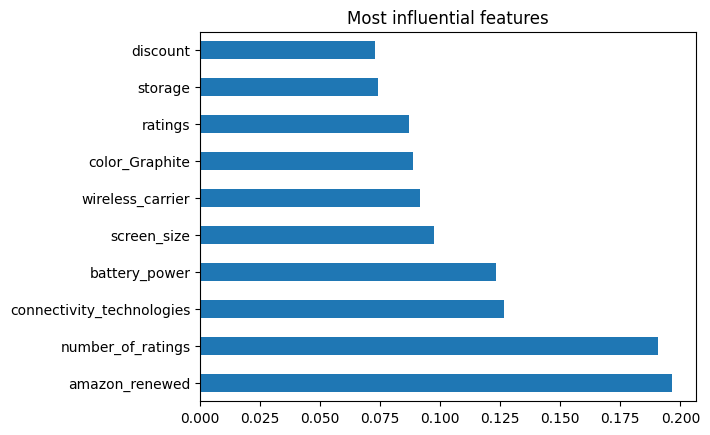

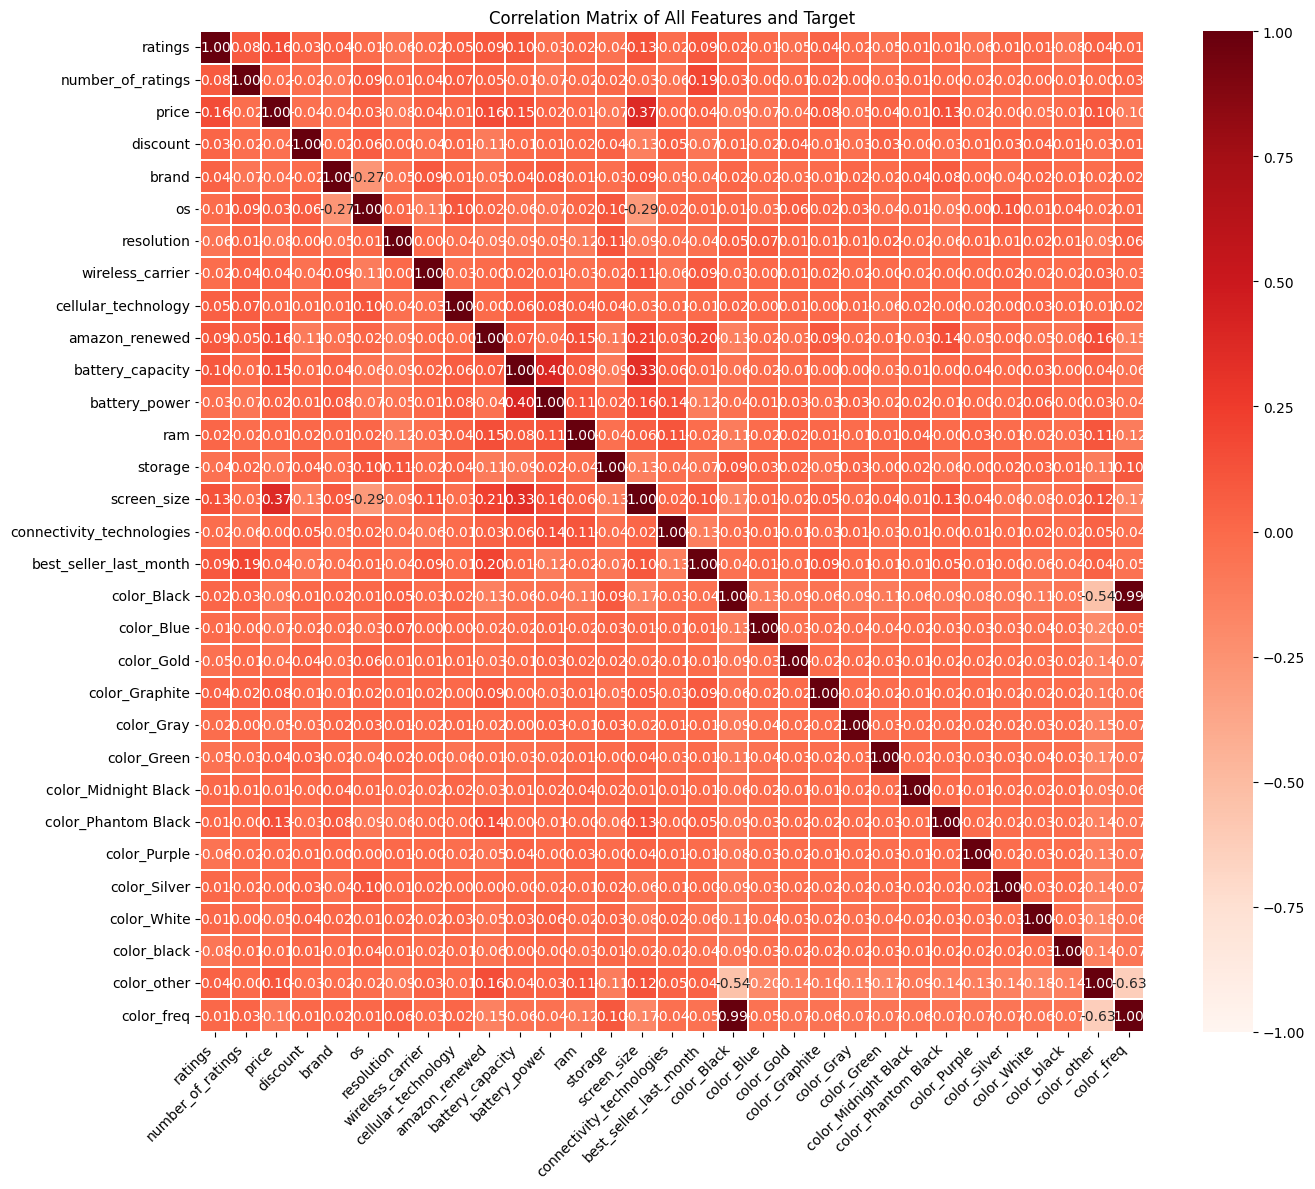

In [289]:
import seaborn as sns, matplotlib.pyplot as plt
corr = pd.DataFrame(X_all, columns=feature_names).assign(target=y).corr()
top_corr = corr['target'].abs().sort_values(ascending=False)[1:11]
top_corr.plot.barh(); plt.title('Most influential features'); plt.show()

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data_corr = data.copy()
data_corr['best_seller_last_month'] = y

# Compute correlation matrix
corr_matrix = data_corr.corr()

# Plot full heatmap
plt.figure(figsize=(14,12))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='Reds',
    vmin=-1,
    vmax=1,
    linewidths=0.3
)
plt.title("Correlation Matrix of All Features and Target")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

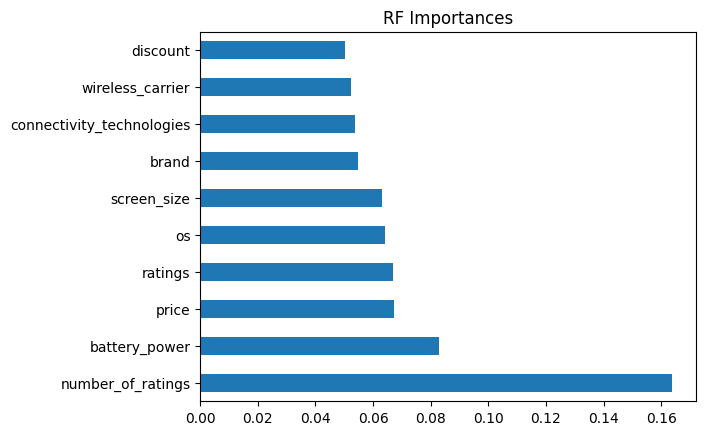

In [290]:
from sklearn.ensemble import RandomForestClassifier
rf0 = RandomForestClassifier(class_weight='balanced', random_state=42)
rf0.fit(X_all, y)
pd.Series(rf0.feature_importances_, index=feature_names).sort_values(ascending=False).head(10).plot.barh(); plt.title('RF Importances'); plt.show()

In [312]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)
from sklearn.model_selection import train_test_split

selected_features = [
    'number_of_ratings',
    'ratings',
    'amazon_renewed',
    'price',
    'discount',
    'battery_power',
    'os',
    'storage',
    'wireless_carrier',
    'screen_size',
    'connectivity_technologies',
]

# Make sure these names exactly match the columns in your cleaned DataFrame `df`
print("Selected features:", selected_features)

# Now extract X using exactly those columns:
X_all_df = pd.DataFrame(X_all, columns=feature_names)  # recreate DataFrame with scaled data
X = X_all_df[selected_features].values


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

#Train-Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# Logistic Regression Model Training
lr = LogisticRegression(
    penalty='l1',            
    C= 10,
    solver='liblinear',
    max_iter=2000,            
    class_weight='balanced',  
    random_state=42)          
    
lr.fit(X_train, y_train)

# Random Forest Model Training 
rf = RandomForestClassifier(
    bootstrap=False, 
    max_depth=10, 
    min_samples_split=5, 
    n_estimators=50,
    random_state=42)
rf.fit(X_train, y_train)



def evaluate(model, name):
    y_pred = model.predict(X_test)
    target_names = [ 'Not-Best-Seller', 'Best-Seller']

    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro')
    rec  = recall_score(y_test, y_pred, average='macro')
    f1   = f1_score(y_test, y_pred, average='macro')
    print(classification_report(y_test, y_pred, target_names=target_names))

    print(f"\n=== {name} ===")
    print(f"Accuracy     : {acc:.3f}")
    print(f"Precision    : {prec:.3f}")
    print(f"Recall       : {rec:.3f}")
    print(f"F1-score     : {f1:.3f}")


evaluate(lr, "Logistic Regression")
evaluate(rf, "Random Forest")


Selected features: ['number_of_ratings', 'ratings', 'amazon_renewed', 'price', 'discount', 'battery_power', 'os', 'storage', 'wireless_carrier', 'screen_size', 'connectivity_technologies']
                 precision    recall  f1-score   support

Not-Best-Seller       0.92      0.70      0.80       724
    Best-Seller       0.28      0.67      0.39       126

       accuracy                           0.70       850
      macro avg       0.60      0.68      0.60       850
   weighted avg       0.83      0.70      0.74       850


=== Logistic Regression ===
Accuracy     : 0.696
Precision    : 0.602
Recall       : 0.684
F1-score     : 0.596
                 precision    recall  f1-score   support

Not-Best-Seller       0.90      0.99      0.94       724
    Best-Seller       0.88      0.36      0.51       126

       accuracy                           0.90       850
      macro avg       0.89      0.67      0.73       850
   weighted avg       0.90      0.90      0.88       850


=== Ran

In [292]:
from sklearn.model_selection import GridSearchCV

LRparam_grid = {
    'C': [0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l1', 'l2'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}
LR_search = GridSearchCV(
    lr, param_grid=LRparam_grid, 
    refit = True, 
    verbose = 3, 
    cv=5
)

LR_search.fit(X_train , y_train)
LR_search.best_params_

# Summary
print('Mean Accuracy: %.3f' % LR_search.best_score_)
print('Config: %s' % LR_search.best_params_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV 1/5] END C=0.01, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=0.01, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=0.01, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=0.01, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=0.01, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END ....C=0.01, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END ....C=0.01, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END ....C=0.01, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END ....C=0.01, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END ....C=0.01, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5] END C=0.01, penalty=l1, solver=liblinear;, score=0.638 total time=   0.0s
[CV 2/5] END C=0.01, penalty=l1, solver=libli

/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
90 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1363, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1210, in fit
    solve

In [293]:
RFparam_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid=RFparam_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Optimal Parameters:", grid_search.best_params_)

Optimal Parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}


In [294]:
#Random Search hyperparameter tuning for RF

from sklearn.model_selection import RandomizedSearchCV
random_search = RandomizedSearchCV(RandomForestClassifier(),
                                   RFparam_grid)
random_search.fit(X_train, y_train)
print(random_search.best_estimator_)

RandomForestClassifier(bootstrap=False, max_depth=10, min_samples_split=5,
                       n_estimators=50)
